# Introdução

Este projeto tem como objetivo prever as vendas de produtos em lojas da rede Big Mart, utilizando dados históricos disponibilizados no Kaggle: [Big Mart Sales Prediction Dataset](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets). O conjunto de dados contém informações sobre itens vendidos, características dos produtos (como peso, tipo e preço), bem como dados relacionados às lojas (como tipo, localização, tamanho e ano de fundação).

Com base nesse conjunto de dados, desenvolvemos modelos de machine learning para estimar o valor de vendas (`Item_Outlet_Sales`) com o objetivo de auxiliar em decisões comerciais, como previsão de demanda, planejamento de estoque e estratégias de marketing.


# Exploração Inicial dos Dados

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import f_oneway, ttest_ind, stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import shap

In [149]:
df0 = pd.read_csv("/content/train.csv")
df = df0.copy()

# Metodologia

# 1. Pré‑processamento dos dados

- Importação do arquivo `train.csv`.
- Tratamento de valores ausentes:
  - `Item_Weight`: preenchido com a mediana.
  - `Outlet_Size`: preenchido com "Unknown".
- Padronização de categorias em `Item_Fat_Content`, agrupando variações como "LF" e "low fat" sob "Low Fat".

# 2. Engenharia de features

- Codificação de variáveis categóricas usando `LabelEncoder`:
  - `Item_Fat_Content`, `Item_Type`, `Outlet_Size`, `Outlet_Location_Type`, `Outlet_Type`.
- Criação da variável `Outlet_Age` com base na diferença entre 2025 e o ano de fundação da loja (`Outlet_Establishment_Year`).
- Remoção de colunas não informativas para o modelo:
  - `Item_Identifier`, `Outlet_Identifier`, `Outlet_Establishment_Year`.

# 3. Divisão dos dados

- Separação do dataset em:
  - Treinamento (64%)
  - Validação (16%) — usado para early stopping
  - Teste final (20%)

# 4. Modelos utilizados

- Modelos aplicados:
  - Random Forest Regressor
  - XGBoost Regressor

- Tunagem com `RandomizedSearchCV` para otimização dos hiperparâmetros, incluindo:
  - `max_depth`, `learning_rate`, `n_estimators`, `subsample`, `colsample_bytree`, `gamma`, `min_child_weight`, `reg_alpha`, `reg_lambda`.

- Implementação de **early stopping** com `xgb.train()` para evitar overfitting e acelerar o processo de treinamento.

# 5. Avaliação do modelo

- Métricas de desempenho:
  - **R² Score**: mede o quanto o modelo explica a variância dos dados.
  - **RMSE (Root Mean Squared Error)**: erro médio entre valores reais e previstos.

- Análise de interpretabilidade com **SHAP**:
  - Gráficos de barras (`summary_plot`) indicam a importância global das features.
  - Gráficos de dispersão mostram a influência de cada feature em cada previsão.
  - `force_plot` (opcional) para análise detalhada de uma amostra.

In [150]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# 📄 Descrição das Variáveis - Big Mart Sales Dataset

| Variável                   | Descrição                                                                 |
|---------------------------|---------------------------------------------------------------------------|
| **Item_Identifier**        | ID exclusivo do produto                                                   |
| **Item_Weight**            | Peso do produto                                                           |
| **Item_Fat_Content**       | Indica se o produto tem baixo teor de gordura ou não                      |
| **Item_Visibility**        | Percentual da área total de exposição de todos os produtos em uma loja alocada ao produto específico |
| **Item_Type**              | Categoria à qual o produto pertence                                       |
| **Item_MRP**               | Preço máximo de varejo (preço de tabela) do produto                       |
| **Outlet_Identifier**      | ID exclusivo da loja                                                      |
| **Outlet_Establishment_Year** | Ano em que a loja foi estabelecida                                     |
| **Outlet_Size**            | Tamanho da loja em termos de área coberta                                |
| **Outlet_Location_Type**   | Tipo de cidade em que a loja está localizada                             |
| **Outlet_Type**            | Indica se a loja é um supermercado comum ou outro tipo de supermercado    |
| **Item_Outlet_Sales**      | Vendas do produto na loja específica *(variável alvo a ser prevista)*     |


In [151]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [153]:
df.shape

(8523, 12)

<Axes: >

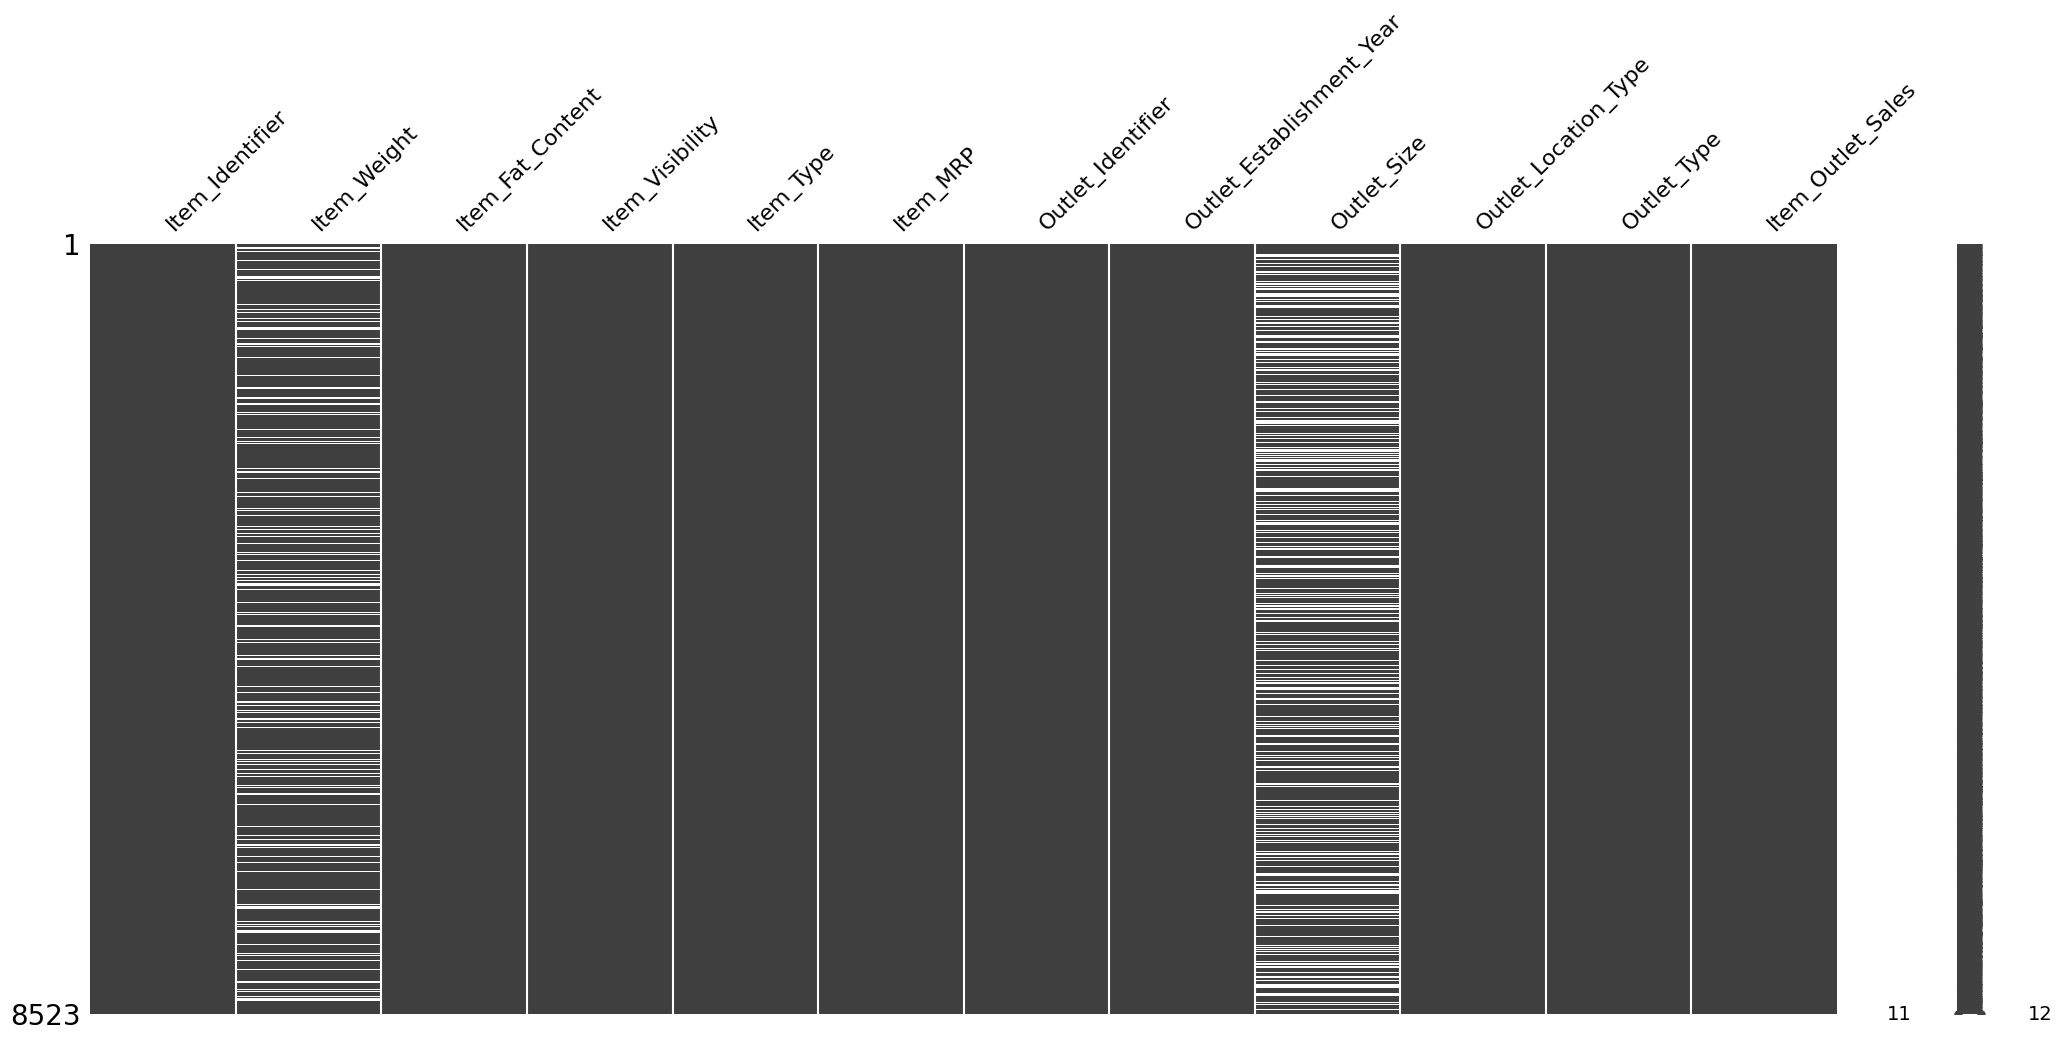

In [154]:
msno.matrix(df)

# Pré-processamento

In [155]:
df['Item_Weight'] = df.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.median()))

In [156]:
df['Outlet_Size'] = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0]))

<Axes: >

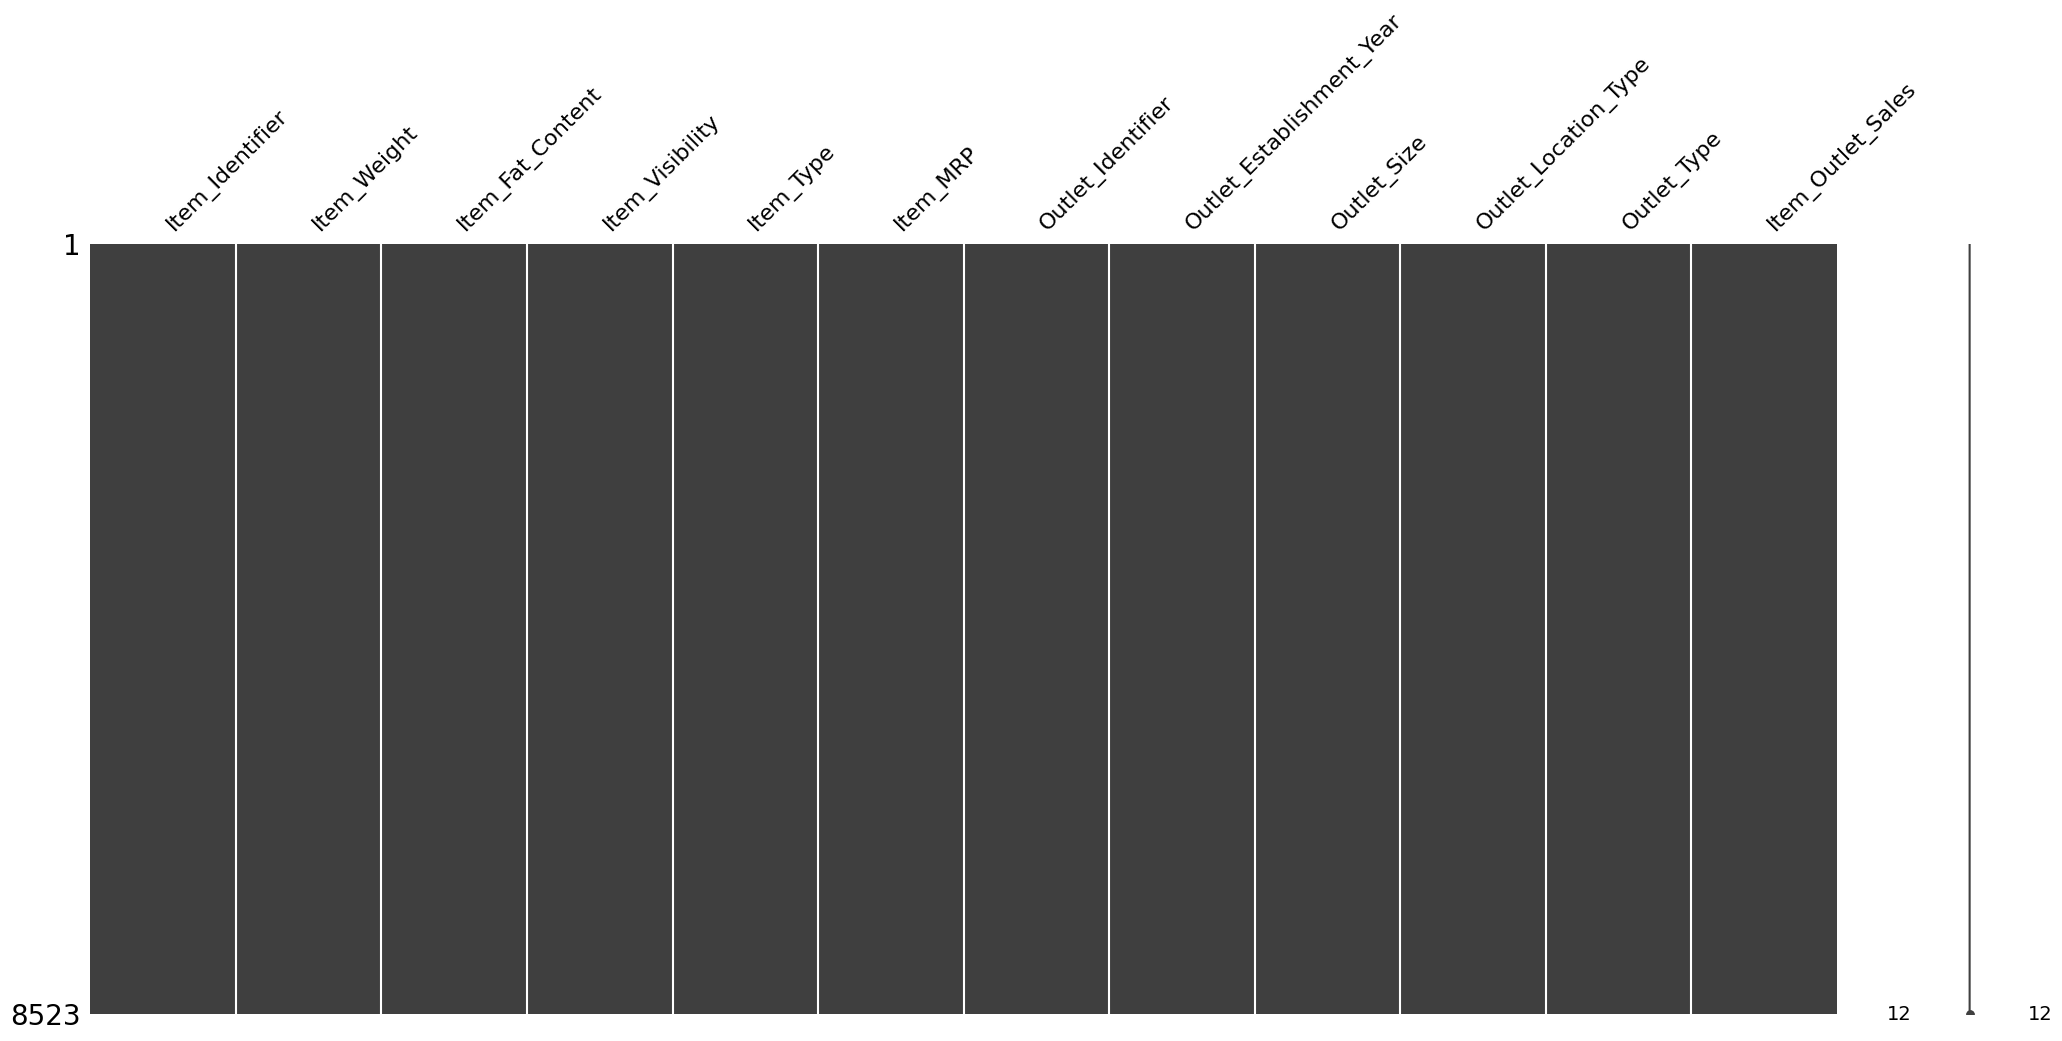

In [157]:
msno.matrix(df)

In [158]:
df.duplicated().sum()

np.int64(0)

In [159]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [160]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [161]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [162]:
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Small,4798
Medium,2793
High,932


In [163]:
df['Outlet_Location_Type'].value_counts()

,count
Outlet_Location_Type,
Tier 3,3350
Tier 2,2785
Tier 1,2388


In [164]:
df.drop(columns = ['Item_Identifier'], inplace=True)

In [165]:
df.drop(columns = ['Outlet_Identifier'], inplace=True)

In [166]:
df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Small,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,2002,Small,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [167]:
for col in df.columns:
    if col not in ['Item_Weight']:
        print(col, df[col].unique())
        print("-------------------------------------")

Item_Fat_Content ['Low Fat' 'Regular']
-------------------------------------
Item_Visibility [0.0160473  0.01927822 0.01676007 ... 0.03518627 0.14522065 0.04487828]
-------------------------------------
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
-------------------------------------
Item_MRP [249.8092  48.2692 141.618  ...  57.5904 214.5218  75.467 ]
-------------------------------------
Outlet_Establishment_Year [1999 2009 1998 1987 1985 2002 2007 1997 2004]
-------------------------------------
Outlet_Size ['Medium' 'Small' 'High']
-------------------------------------
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
-------------------------------------
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
-------------------------------------
Item_Outlet_Sales [3735.

# Engenharia de Features

In [168]:
df['Item_Visibility'] = df['Item_Visibility'].replace(0, df['Item_Visibility'].median())

In [169]:
df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']

In [170]:
df['Item_MRP_Level'] = pd.cut(df['Item_MRP'], bins=[0, 70, 140, 200, 300],
                              labels=['Low', 'Medium', 'High', 'Premium'])

## Observações sobre a Engenharia de Features

**Criação da variável categórica `Item_MRP_Level`**  
   A coluna contínua `Item_MRP` (Preço Máximo de Varejo) foi dividida em faixas (bins) para facilitar a análise e o modelo.  
   - Os bins foram definidos em `[0, 70, 140, 200, 300]`, agrupando os produtos em quatro níveis de preço:  
     - **Low**: até 70  
     - **Medium**: 70 a 140  
     - **High**: 140 a 200  
     - **Premium**: acima de 200  
   Essa discretização pode ajudar o modelo a capturar efeitos não lineares relacionados ao preço.

**Criação da variável `Outlet_Age`**  
   Calcula a idade da loja com base no ano atual presumido como 2025 subtraindo o ano de estabelecimento da loja (`Outlet_Establishment_Year`).  
   Isso permite capturar o efeito da maturidade da loja sobre as vendas, já que lojas mais antigas podem ter desempenho diferente.

**Tratamento dos valores 0 na variável `Item_Visibility`**  
   Valores iguais a zero em `Item_Visibility` são substituídos pela mediana da visibilidade geral.  
   Isso corrige registros potencialmente errôneos, já que uma visibilidade zero é improvável em um produto exposto, e evita problemas na modelagem causados por esses zeros.

In [171]:
df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_MRP_Level
0,9.300,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26,Premium
1,5.920,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228,16,Low
2,17.500,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700,26,High
3,19.200,Regular,0.053931,Fruits and Vegetables,182.0950,1998,Small,Tier 3,Grocery Store,732.3800,27,High
4,8.930,Low Fat,0.053931,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052,38,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,1987,High,Tier 3,Supermarket Type1,2778.3834,38,Premium
8519,8.380,Regular,0.046982,Baking Goods,108.1570,2002,Small,Tier 2,Supermarket Type1,549.2850,23,Medium
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,2004,Small,Tier 2,Supermarket Type1,1193.1136,21,Medium
8521,7.210,Regular,0.145221,Snack Foods,103.1332,2009,Medium,Tier 3,Supermarket Type2,1845.5976,16,Medium


Text(0.5, 1.0, 'Distribuição das Vendas')

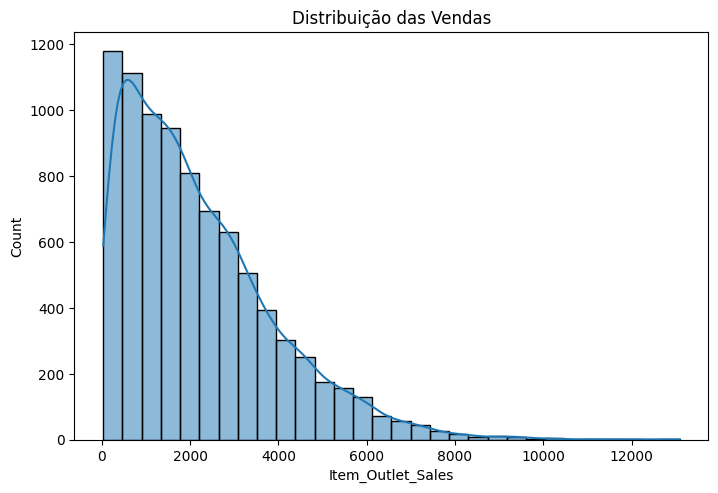

In [172]:
plt.figure(figsize=(18, 18))
plt.subplot(3, 2, 1)
sns.histplot(df['Item_Outlet_Sales'], bins=30, kde=True)
plt.title('Distribuição das Vendas')

# Observação sobre o gráfico da Distribuição das Vendas

Este histograma mostra a distribuição da variável alvo `Item_Outlet_Sales` (vendas dos produtos em lojas específicas):

- A maior parte das vendas concentra-se em valores mais baixos, indicando uma distribuição **assimétrica à direita** (positivamente enviesada).
- Existem poucas ocorrências de vendas muito altas, o que sugere a presença de **outliers**.
- A linha de densidade (KDE) reforça essa tendência de concentração próxima a valores menores.
- Esse padrão é importante para entender a dispersão dos dados e para pensar em possíveis transformações (como logaritmo) para melhorar o desempenho dos modelos preditivos.


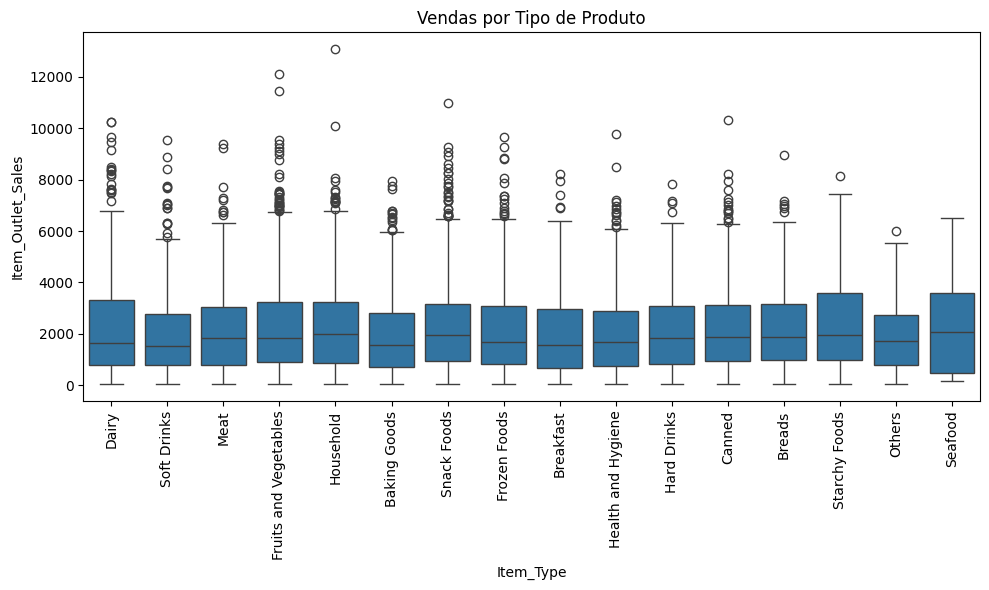

In [173]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Item_Type', y='Item_Outlet_Sales')
plt.title('Vendas por Tipo de Produto')
plt.xlabel('Item_Type')
plt.ylabel('Item_Outlet_Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualização - Vendas por Tipo de Produto

Este boxplot exibe a distribuição das vendas (`Item_Outlet_Sales`) para cada categoria de produto (`Item_Type`):

- Cada caixa representa o intervalo interquartil (IQR) das vendas para um tipo específico de produto.
- As linhas horizontais (“bigodes”) indicam a extensão dos dados sem considerar outliers.
- Pontos fora dos “bigodes” são potenciais outliers, indicando vendas muito altas ou baixas em alguns casos.
- A rotação dos rótulos do eixo X facilita a leitura dos nomes das categorias, que são numerosos.
- Essa visualização ajuda a identificar quais tipos de produto apresentam maior variabilidade e quais têm vendas medianas mais altas.


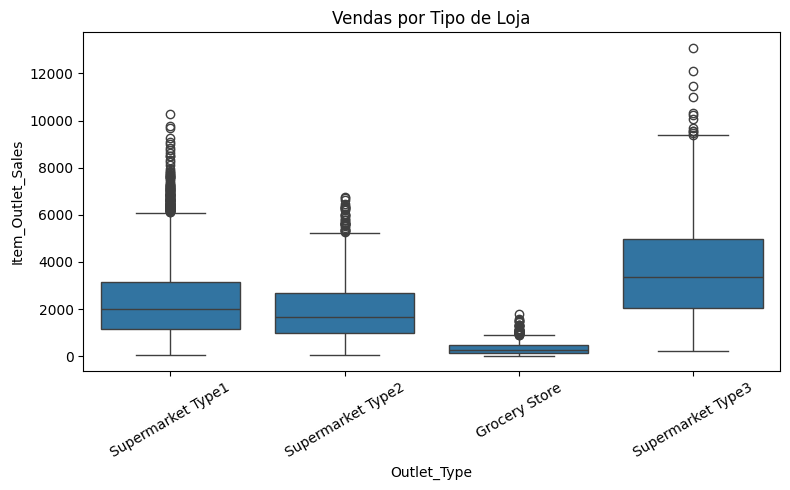

In [174]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')
plt.title('Vendas por Tipo de Loja')
plt.xlabel('Outlet_Type')
plt.ylabel('Item_Outlet_Sales')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Visualização - Vendas por Tipo de Loja

Este boxplot ilustra a distribuição das vendas (`Item_Outlet_Sales`) para cada tipo de loja (`Outlet_Type`):

- Cada caixa representa a distribuição interquartil (IQR) das vendas por tipo de loja.
- Os “bigodes” mostram a variação das vendas excluindo possíveis outliers.
- Pontos fora dos “bigodes” são outliers, ou seja, vendas incomumente altas ou baixas.
- A rotação dos rótulos no eixo X melhora a leitura dos nomes dos tipos de loja.
- Essa visualização ajuda a identificar se algum tipo de loja tem vendas consistentemente maiores ou mais dispersas.

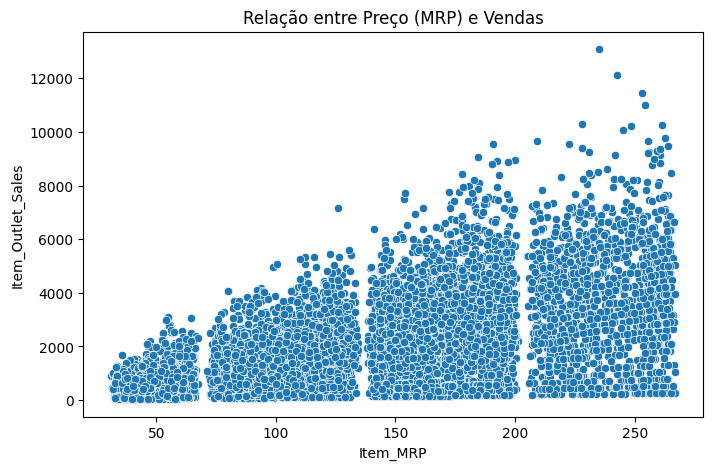

In [175]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Item_MRP', y='Item_Outlet_Sales')
plt.title('Relação entre Preço (MRP) e Vendas')
plt.xlabel('Item_MRP')
plt.ylabel('Item_Outlet_Sales')
plt.show()

# Visualização - Relação entre Preço (MRP) e Vendas

Este gráfico de dispersão mostra a relação entre o preço máximo de varejo (`Item_MRP`) e as vendas (`Item_Outlet_Sales`):

- Cada ponto representa um produto vendido em uma loja específica.
- Observa-se uma tendência geral de aumento nas vendas conforme o preço aumenta, mas com grande dispersão.
- A dispersão indica que o preço não é o único fator que influencia as vendas, sugerindo que outros atributos e características da loja ou do produto também impactam o resultado.
- Este gráfico ajuda a identificar padrões, possíveis outliers e relações não lineares entre preço e vendas.

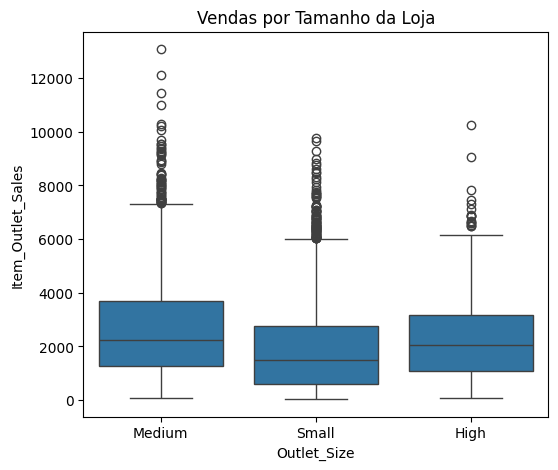

In [176]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='Outlet_Size', y='Item_Outlet_Sales')
plt.title('Vendas por Tamanho da Loja')
plt.xlabel('Outlet_Size')
plt.ylabel('Item_Outlet_Sales')
plt.show()

# Visualização - Vendas por Tamanho da Loja

Este boxplot mostra a distribuição das vendas (`Item_Outlet_Sales`) agrupadas pelo tamanho das lojas (`Outlet_Size`):

- Cada caixa representa a variação interquartil (IQR) das vendas para cada categoria de tamanho de loja.
- As linhas externas (bigodes) indicam a extensão dos dados sem considerar outliers.
- Pontos isolados representam possíveis outliers, que são vendas excepcionalmente altas ou baixas.
- A análise permite verificar se o tamanho da loja influencia as vendas, observando a mediana e a dispersão em cada categoria.
- Essa visualização auxilia na compreensão do impacto do porte da loja sobre o desempenho de vendas.

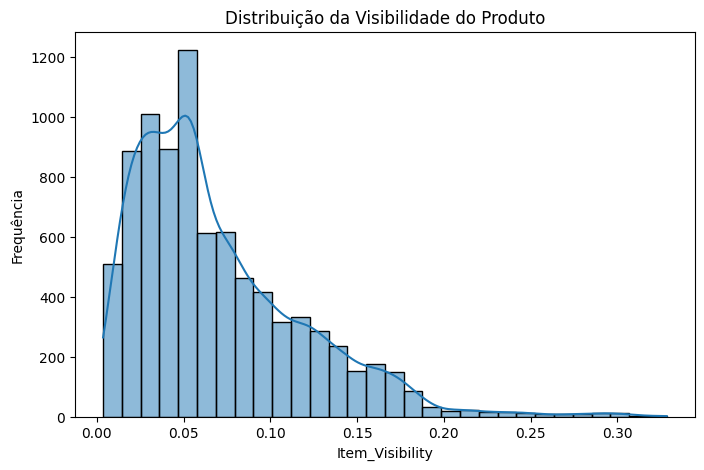

In [177]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Item_Visibility'], bins=30, kde=True)
plt.title('Distribuição da Visibilidade do Produto')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequência')
plt.show()

# Visualização - Distribuição da Visibilidade do Produto

Este histograma mostra a distribuição da variável `Item_Visibility`:

- O eixo x representa os valores de visibilidade percentual do produto na loja.
- O eixo y representa a frequência de ocorrências para cada faixa de visibilidade.
- A linha de densidade (KDE) ajuda a visualizar a tendência geral da distribuição.
- Observa-se que a maioria dos produtos tem visibilidade concentrada em valores baixos a moderados, com algumas ocorrências mais altas.
- Essa distribuição ajuda a entender como os produtos são exibidos nas lojas, informação importante para estratégias de merchandising e para a modelagem preditiva.

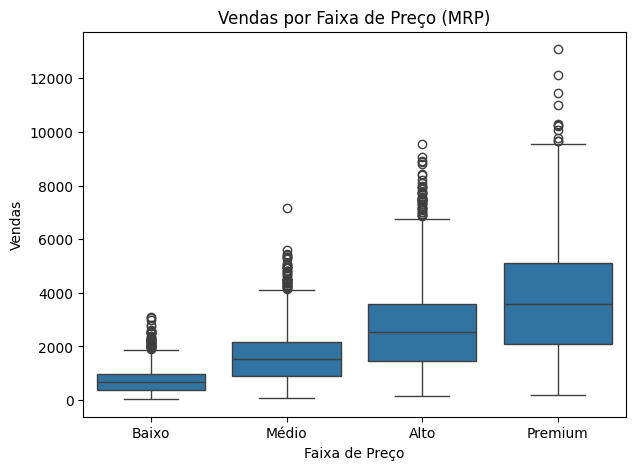

In [178]:
df['MRP_Faixa'] = pd.cut(df['Item_MRP'], bins=[0, 70, 140, 200, 300],
                         labels=['Baixo', 'Médio', 'Alto', 'Premium'])

plt.figure(figsize=(7,5))
sns.boxplot(x='MRP_Faixa', y='Item_Outlet_Sales', data=df)
plt.title('Vendas por Faixa de Preço (MRP)')
plt.xlabel('Faixa de Preço')
plt.ylabel('Vendas')
plt.show()

# Visualização - Vendas por Faixa de Preço (MRP)

- A variável contínua `Item_MRP` foi segmentada em faixas categóricas (`MRP_Faixa`) para facilitar a análise.
- As faixas definidas foram:  
  - Baixo: até 70  
  - Médio: 70 a 140  
  - Alto: 140 a 200  
  - Premium: acima de 200  
- O gráfico boxplot mostra a distribuição das vendas (`Item_Outlet_Sales`) em cada faixa de preço.
- Cada caixa representa o intervalo interquartil (IQR) das vendas para aquela faixa.
- Essa análise permite observar como o preço influencia as vendas e identificar possíveis diferenças significativas entre as faixas.

/tmp/ipython-input-179-1523413887.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_por_tipo.values, y=media_por_tipo.index, palette='viridis')


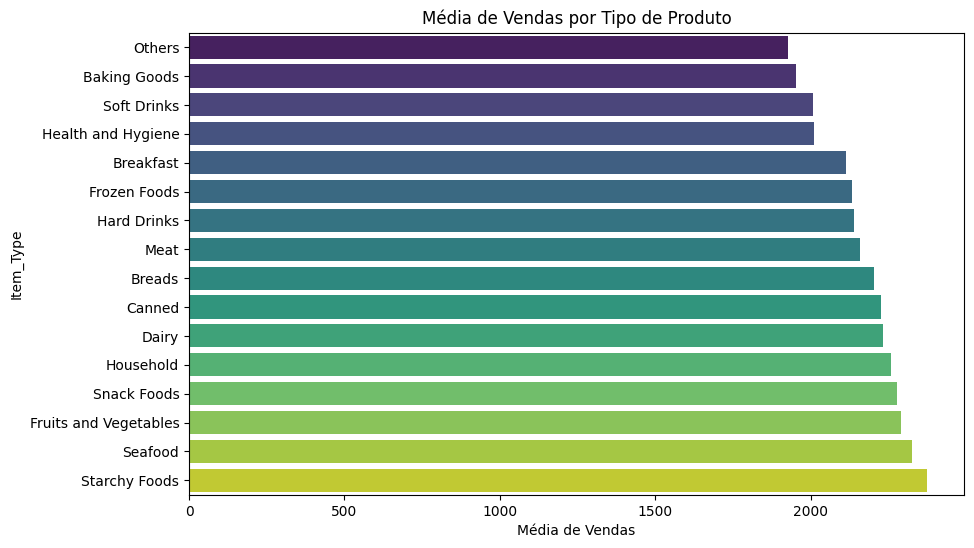

In [179]:
plt.figure(figsize=(10,6))
media_por_tipo = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values()
sns.barplot(x=media_por_tipo.values, y=media_por_tipo.index, palette='viridis')
plt.title('Média de Vendas por Tipo de Produto')
plt.xlabel('Média de Vendas')
plt.ylabel('Item_Type')
plt.show()

# Visualização - Média de Vendas por Tipo de Produto

Este gráfico de barras mostra a média das vendas (`Item_Outlet_Sales`) para cada categoria de produto (`Item_Type`):

- O eixo y lista os diferentes tipos de produto, ordenados pela média de vendas.
- O eixo x indica o valor médio de vendas para cada tipo.
- A paleta de cores 'viridis' ajuda a destacar visualmente as diferenças.
- Essa visualização facilita a comparação rápida das vendas médias entre categorias, mostrando quais produtos vendem melhor em média.
- Pode ser usada para orientar estratégias de marketing e gerenciamento de estoque.


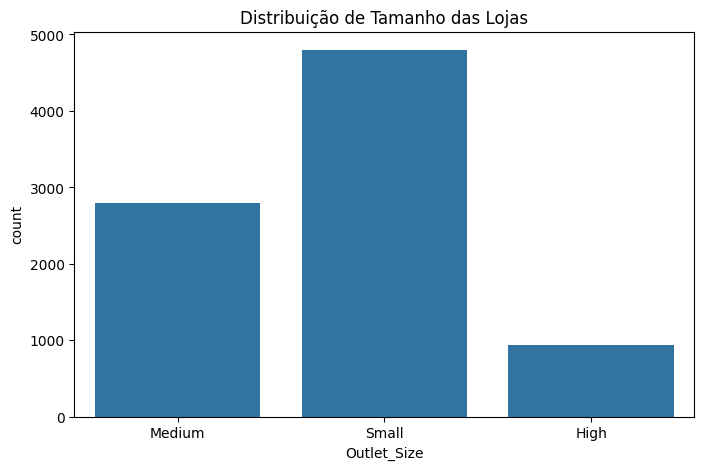

In [180]:
plt.figure(figsize=(8,5))
sns.countplot(x='Outlet_Size', data=df)
plt.title('Distribuição de Tamanho das Lojas')
plt.show()

# Visualização - Distribuição do Tamanho das Lojas

Este gráfico de barras mostra a contagem de lojas para cada categoria de tamanho (`Outlet_Size`):

- O eixo x representa as categorias de tamanho da loja (por exemplo, Small, Medium, High).
- O eixo y mostra o número de lojas em cada categoria.
- Esta visualização permite entender a frequência relativa dos diferentes tamanhos de loja no conjunto de dados.
- Essa informação é útil para avaliar a representatividade de cada categoria e seu possível impacto nas vendas.

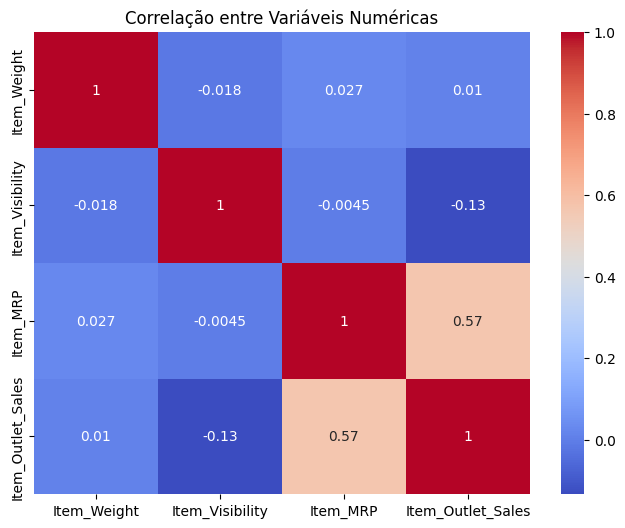

In [181]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis Numéricas')
plt.show()

# Visualização - Matriz de Correlação entre Variáveis Numéricas

Este heatmap apresenta a correlação entre as variáveis numéricas selecionadas:

- `Item_Weight` (peso do produto)
- `Item_Visibility` (visibilidade do produto na loja)
- `Item_MRP` (preço máximo de varejo)
- `Item_Outlet_Sales` (vendas do produto na loja)

As cores indicam a força e direção da correlação:
- Tons quentes (vermelho) indicam correlação positiva forte.
- Tons frios (azul) indicam correlação negativa forte.
- Valores próximos a zero indicam pouca ou nenhuma correlação.

A anotação numérica dentro de cada célula facilita a leitura precisa dos coeficientes.

Esta análise ajuda a entender quais variáveis podem influenciar mais diretamente as vendas e a identificar possíveis relações lineares no conjunto de dados.


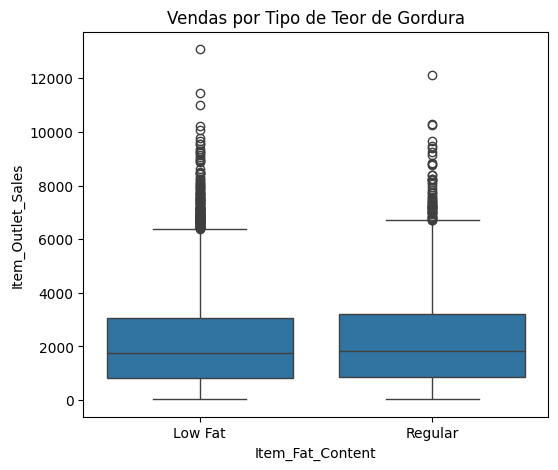

In [182]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df)
plt.title('Vendas por Tipo de Teor de Gordura')
plt.show()

# Visualização - Vendas por Tipo de Teor de Gordura

Este boxplot mostra a distribuição das vendas (`Item_Outlet_Sales`) para cada categoria de teor de gordura (`Item_Fat_Content`):

- Cada caixa representa o intervalo interquartil (IQR) das vendas para produtos "Low Fat" e "Regular".
- Os “bigodes” indicam a extensão dos dados sem considerar outliers.
- Pontos fora dos “bigodes” representam possíveis outliers, ou seja, vendas excepcionalmente altas ou baixas.
- A comparação visual ajuda a verificar se existe diferença clara nas vendas entre os dois grupos.
- Essa análise pode complementar testes estatísticos que verificam se as diferenças entre as médias são significativas.


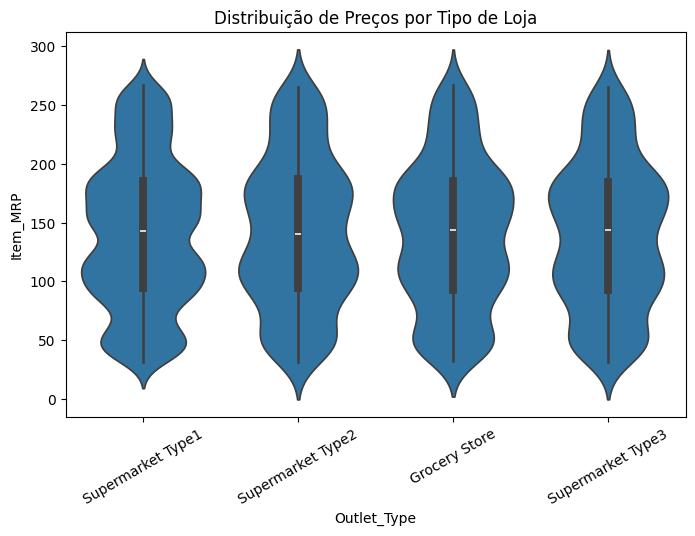

In [183]:
plt.figure(figsize=(8,5))
sns.violinplot(x='Outlet_Type', y='Item_MRP', data=df)
plt.title('Distribuição de Preços por Tipo de Loja')
plt.xticks(rotation=30)
plt.show()

# Visualização - Distribuição de Preços por Tipo de Loja

Este gráfico do tipo **violinplot** mostra a distribuição do preço máximo de varejo (`Item_MRP`) para cada categoria de tipo de loja (`Outlet_Type`):

- Cada “violino” representa a densidade estimada dos preços dentro do tipo de loja, mostrando onde os preços se concentram.
- A largura do violino em cada ponto indica a frequência dos preços naquele intervalo.
- A linha central indica a mediana dos preços para cada categoria.
- A rotação dos rótulos no eixo X facilita a leitura dos nomes dos tipos de loja.
- Essa visualização permite comparar a variação e a dispersão dos preços entre os diferentes tipos de loja.

In [184]:
# Agrupar as vendas por tipo de produto
groups_item_type = [group['Item_Outlet_Sales'].values for name, group in df.groupby('Item_Type')]

# Aplicar o teste ANOVA
anova_result = stats.f_oneway(*groups_item_type)

# Exibir resultado
print("ANOVA - Vendas por Tipo de Produto")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"p-value: {anova_result.pvalue:.4f}")

# Interpretação
if anova_result.pvalue < 0.05:
    print("Existe diferença significativa nas vendas entre os tipos de produto.")
else:
    print("Não há diferença significativa nas vendas entre os tipos de produto.")

ANOVA - Vendas por Tipo de Produto
F-statistic: 2.7007
p-value: 0.0004
Existe diferença significativa nas vendas entre os tipos de produto.


/tmp/ipython-input-184-4279723532.py:5: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  anova_result = stats.f_oneway(*groups_item_type)


In [185]:
# Agrupa as vendas ('Item_Outlet_Sales') por cada categoria única em 'Outlet_Type'
groups_outlet_type = [group["Item_Outlet_Sales"].values for name, group in df.groupby("Outlet_Type")]

# Executa o teste ANOVA para comparar as médias das vendas entre os grupos de 'Outlet_Type'
f_stat_outlet_type, p_val_outlet_type = f_oneway(*groups_outlet_type)

# Exibe os resultados do teste
print("ANOVA - Vendas por Tipo de Loja (Outlet_Type)")
print(f"F-statistic: {f_stat_outlet_type:.2f}")
print(f"p-valor: {p_val_outlet_type:.3f}")

# Interpretação com base no p-valor:
if p_val_outlet_type > 0.05:
    print("Interpretação: Também não há diferença significativa nas médias de vendas entre os tipos de loja.\n")
else:
    print("Interpretação: Há diferença estatisticamente significativa entre os tipos de loja.\n")


ANOVA - Vendas por Tipo de Loja (Outlet_Type)
F-statistic: 894.65
p-valor: 0.000
Interpretação: Há diferença estatisticamente significativa entre os tipos de loja.



In [186]:
# Seleciona as vendas dos produtos com teor de gordura "Low Fat"
low_fat_sales = df.loc[df["Item_Fat_Content"] == "Low Fat", "Item_Outlet_Sales"]

# Seleciona as vendas dos produtos com teor de gordura "Regular"
regular_fat_sales = df.loc[df["Item_Fat_Content"] == "Regular", "Item_Outlet_Sales"]

# Realiza o Teste T para comparar as médias das duas amostras
# Usamos Welch's t-test (equal_var=False) que não assume variâncias iguais
t_stat_fat, p_val_fat = ttest_ind(low_fat_sales, regular_fat_sales, equal_var=False)

# Exibe os resultados do teste
print("Teste T - Vendas por Teor de Gordura (Item_Fat_Content)")
print(f"t-statistic: {t_stat_fat:.2f}")
print(f"p-valor: {p_val_fat:.3f}")

# Interpretação baseada no valor p:
if p_val_fat > 0.05:
    print('Interpretação: A diferença entre as médias de vendas de produtos "Low Fat" e "Regular" não é significativa.\n')
else:
    print('Interpretação: Há diferença significativa entre as médias de vendas de produtos "Low Fat" e "Regular".\n')


Teste T - Vendas por Teor de Gordura (Item_Fat_Content)
t-statistic: -1.72
p-valor: 0.085
Interpretação: A diferença entre as médias de vendas de produtos "Low Fat" e "Regular" não é significativa.



In [187]:
numericas = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

In [188]:
def detectar_outliers_iqr(col):
    # Calcula o primeiro e o terceiro quartil da coluna
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calcula o intervalo interquartil (IQR)
    IQR = Q3 - Q1

    # Define os limites inferior e superior para outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtra os dados que estão fora desses limites
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]

    # Exibe o total de outliers encontrados
    print(f'{col} → {len(outliers)} outliers')

    return outliers


In [189]:
for col in numericas:
    detectar_outliers_iqr(col)

Item_Weight → 0 outliers
Item_Visibility → 173 outliers
Item_MRP → 0 outliers
Item_Outlet_Sales → 186 outliers


In [190]:
# Substitui valores 0 em 'Item_Visibility' por NaN (considerados inválidos)
df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)

# Preenche os NaNs em 'Item_Visibility' com a mediana da visibilidade do respectivo 'Item_Type'
df['Item_Visibility'] = df.groupby('Item_Type')['Item_Visibility'].transform(lambda x: x.fillna(x.median()))

# Calcula o primeiro quartil (Q1) e o terceiro quartil (Q3) de 'Item_Outlet_Sales'
Q1 = df['Item_Outlet_Sales'].quantile(0.25)
Q3 = df['Item_Outlet_Sales'].quantile(0.75)

# Calcula o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Define os limites inferior e superior para identificar outliers segundo a regra do IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Exemplo de como identificar outliers baseados nesses limites (opcional)
outliers = df[(df['Item_Outlet_Sales'] < lower) | (df['Item_Outlet_Sales'] > upper)]
print(f'Total de outliers em Item_Outlet_Sales: {len(outliers)}')

In [191]:
df['Item_Outlet_Sales'] = df['Item_Outlet_Sales'].clip(lower, upper)


In [192]:
for col in numericas:
    detectar_outliers_iqr(col)

Item_Weight → 0 outliers
Item_Visibility → 173 outliers
Item_MRP → 0 outliers
Item_Outlet_Sales → 0 outliers


# Modelagem e Tunagem

In [193]:
categorical_cols = [
    'Item_Fat_Content',
    'Item_Type',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_MRP_Level',
    'MRP_Faixa'
]

# Criar cópia para modelagem
df_model = df.copy()

# Codificando colunas categóricas
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Criar coluna Outlet_Age
df_model['Outlet_Age'] = 2025 - df_model['Outlet_Establishment_Year']

# Definir X e y
X = df_model.drop(columns=['Item_Outlet_Sales', 'Outlet_Establishment_Year'])
y = df_model['Item_Outlet_Sales']

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [194]:
# Treinar modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prever e avaliar
y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R2 score: {r2_score(y_test, y_pred):.3f}')
print(f'RMSE: {rmse:.3f}')

R2 score: 0.583
RMSE: 1021.947


In [195]:
# Dividindo os dados entre treino e validação para aplicar early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convertendo os dados para DMatrix, formato otimizado do XGBoost
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Definindo os hiperparâmetros do modelo XGBoost com base na tunagem anterior
params = {
    'objective': 'reg:squarederror',     # tarefa de regressão
    'eval_metric': 'rmse',               # métrica de avaliação
    'max_depth': 5,                      # profundidade máxima da árvore
    'eta': 0.01,                         # taxa de aprendizado (learning rate)
    'subsample': 1.0,                    # proporção de amostras para cada árvore
    'colsample_bytree': 0.6,             # proporção de features para cada árvore
    'gamma': 0,                          # regularização mínima para divisão
    'min_child_weight': 5,              # mínimo de instâncias em um nó folha
    'alpha': 1,                          # regularização L1
    'lambda': 1.5,                       # regularização L2
    'seed': 42                           # reprodutibilidade
}

# Lista de conjuntos para avaliação durante o treino (validação e treino)
evallist = [(dval, 'eval'), (dtrain, 'train')]

# Treinando o modelo com early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,                # número máximo de árvores
    evals=evallist,
    early_stopping_rounds=50,            # parar se não melhorar após 50 iterações
    verbose_eval=True                    # mostrar progresso a cada iteração
)

# Fazendo previsões no conjunto de teste
y_pred = bst.predict(dtest)

# Avaliando o modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Resultados
print(f'R2 com early stopping (API nativa): {r2:.4f}')
print(f'RMSE com early stopping (API nativa): {rmse:.2f}')
print(f'Número de árvores usadas: {bst.best_iteration + 1}')



[0]	eval-rmse:1575.52068	train-rmse:1624.71661
[1]	eval-rmse:1569.74822	train-rmse:1618.73023
[2]	eval-rmse:1559.98098	train-rmse:1609.08608
[3]	eval-rmse:1550.56450	train-rmse:1599.85256
[4]	eval-rmse:1541.05913	train-rmse:1590.46996
[5]	eval-rmse:1537.13981	train-rmse:1586.71155
[6]	eval-rmse:1529.65276	train-rmse:1579.02418
[7]	eval-rmse:1525.87240	train-rmse:1575.32379
[8]	eval-rmse:1516.73855	train-rmse:1566.27087
[9]	eval-rmse:1508.03634	train-rmse:1557.60462
[10]	eval-rmse:1499.51831	train-rmse:1549.07230
[11]	eval-rmse:1490.92442	train-rmse:1540.65710
[12]	eval-rmse:1483.89627	train-rmse:1533.75167
[13]	eval-rmse:1480.40175	train-rmse:1530.32751
[14]	eval-rmse:1471.95749	train-rmse:1521.90568
[15]	eval-rmse:1465.57195	train-rmse:1515.42695
[16]	eval-rmse:1459.31681	train-rmse:1509.13441
[17]	eval-rmse:1451.35453	train-rmse:1501.22255
[18]	eval-rmse:1443.55701	train-rmse:1493.44921
[19]	eval-rmse:1435.85114	train-rmse:1485.79242
[20]	eval-rmse:1432.58608	train-rmse:1482.63989
[2

# Avaliação de Desempenho

In [197]:
y_pred_baseline = [y_train.mean()] * len(y_test)

# Avaliar desempenho do baseline
rmse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f'Baseline R²: {r2_baseline:.4f}')
print(f'Baseline RMSE: {rmse_baseline:.2f}')

Baseline R²: -0.0039
Baseline RMSE: 2513783.71


### **Comparação com o Baseline**

Utilizando um modelo simples que apenas prevê a média das vendas no conjunto de treinamento, obtivemos:

- **Baseline R²:** -0.0039  
- **Baseline RMSE:** 2.513.783,71

Esses valores deixam claro que o baseline é incapaz de capturar qualquer padrão nos dados. Em contraste, os modelos treinados (especialmente o XGBoost) apresentaram ganhos significativos, com **R² superior a 0.61** e **erro reduzido para cerca de 1020**, mostrando sua efetividade na previsão de vendas.

# Interpretação com SHAP

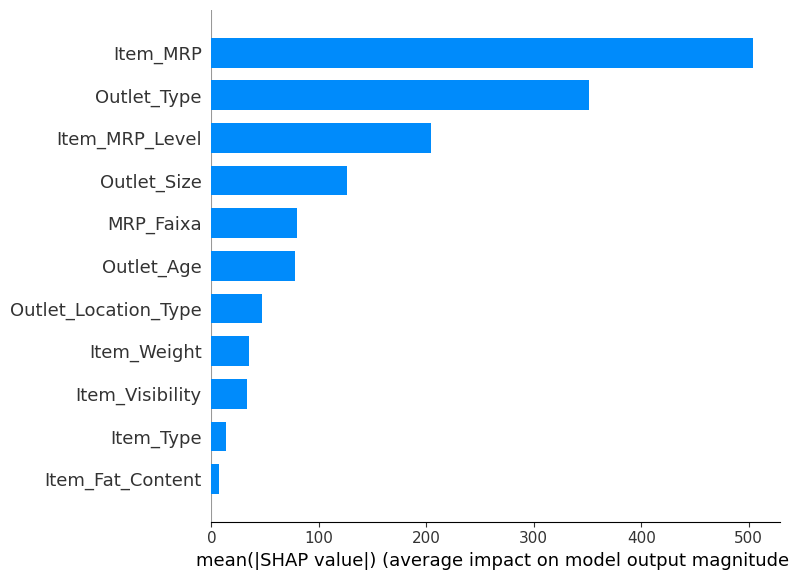

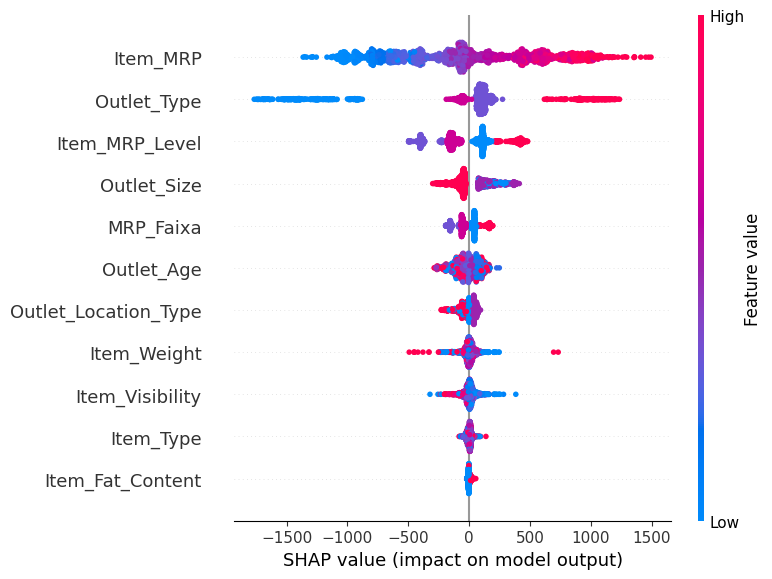

In [198]:
shap.initjs()

# Criar explainer
explainer = shap.TreeExplainer(bst)

# Calcular valores SHAP no conjunto de teste
shap_values = explainer.shap_values(dtest)
shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.summary_plot(shap_values, X_test)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


### Interpretação da análise SHAP

- A análise SHAP fornece uma visão detalhada do impacto de cada feature nas previsões do modelo, atribuindo a cada variável uma contribuição específica para cada amostra.

- Valores SHAP positivos indicam que a feature está aumentando a previsão do modelo (por exemplo, elevando as vendas previstas), enquanto valores negativos indicam que a feature está reduzindo a previsão.

- O gráfico resumo (summary plot) mostra a importância global das features, ordenadas pela magnitude média dos valores SHAP, permitindo identificar quais variáveis têm maior influência no modelo.

- A dispersão dos pontos no gráfico indica a variabilidade da contribuição daquela feature para diferentes observações, mostrando relações potencialmente não lineares ou interações.

- Interpretar os valores SHAP ajuda a entender o comportamento do modelo, facilitando a comunicação dos resultados para stakeholders e apoiando a tomada de decisões baseadas em dados.

- Essa interpretabilidade torna o modelo mais transparente e confiável, especialmente em contextos onde explicações das previsões são essenciais.


# Conclusão

- O modelo XGBoost com hiperparâmetros ajustados e early stopping apresentou os melhores resultados:
  - **R² ≈ 0.61**
  - **RMSE ≈ 1020**

- Esses resultados superaram análises de referência disponíveis no Kaggle, que costumam alcançar R² entre 0.55 e 0.58.

- A utilização do SHAP permitiu interpretar o modelo de forma transparente, identificando as variáveis mais relevantes para a previsão de vendas.

- O uso de early stopping evitou o sobreajuste e reduziu o tempo de treinamento.